# **<center>Visualization and Causation Analysis of Vilnius City Traffic<center>**

<img src="references\vilnius.png" align="middle" width="900" height="450">

<br>

**<center>Prepared by: Augustinas Naina</center>**
**<center>With the help of: Vilnius School of AI</center>**
**<center>On: September, 2019</center>**

<br>

<hr>

**<center>Intro:<center>**

<center>It's often speculted that a lot of problems surrounding Vilnius traffic are solved during summer, because, supposedly, when childern are on holidays - parents don't need to drive them anywhere and thus the load on traffic is lower. However, most of this speciulation is observation and sentiment based. Perhaps we could quantify this relationship and formalize it a bit more?</center>

**<center>Plan of attack:<center>**

<center>- Ingest, familiarize with, and prepare the data;</center>
<center>- Analyze the impact that students' holidays have on traffic conditions;</center>
<center>- Interactively visualize the traffic conditions.</center>

<br>
<hr>

<br>

## Table of contents:

- [1. Data exploration and preparation](#1) 
  - [1.1. Repository structure](#1.1) 
  - [1.2. Data acquisition](#1.2) 
  - [1.3. Data exploration](#1.3) 
  - [1.4. Data preparation](#1.4) 
  - [1.5. Result of exploration and preparation part](#1.5)
- [2. Data representation and exploration](#2)
  - [2.1. Transformations for futher analysis](#2.1)
  - [2.2. Transformations for the dashboard](#2.2)
- [3. Causation analysis](#3)
  - [3.1. School holidays.](#3.1)
- [4. Data Visualization and presentation](#4)
  - [4.1. Interactive map of Vilnius traffic during rush hour.](#4.1)

<br>

<hr>

<br>

## **1. Data exploration and preparation** <a class="anchor" id="1"></a>

Purpose of this chapter is to explore the data, sanity-check its most basic properties, and to expose unexpected features as well as to identify and address anomalities and artifacts in the dataset.

Structure of the whole analysis (including this chapter) will be based on the steps described by David Donoho in "50 years of Data Science" paper, link to this resource - https://courses.csail.mit.edu/18.337/2015/docs/50YearsDataScience.pdf.

<br>

### **1.1. Repository structure** <a class="anchor" id="1.1"></a>

Repository contains traffic data for the whole 2018, some loose data from 2015 which we will not use and also - some important intersection mappings with names and coordinates. Traffic data is split by month and placed in a multi-part archive. Link to Vilnius2IN (_"Intelligent and Integrated"_) data repository (i.e. source data for this analysis) - https://github.com/vilnius/traffic.

The following CMD/Bash scripts will clone the repository, merge all archives into one and extract its contents:

##### *For Windows users:*

In [ ]:
!git clone "https://github.com/vilnius/traffic.git"
!copy /b "traffic\2018\*.zip*" "traffic\2018\combined.zip"
!"C:\Program Files\7-Zip\7z.exe" e "traffic\2018\combined.zip" -o"traffic\2018\"


*For Linux/Mac users:*

In [ ]:
!git clone "https://github.com/vilnius/traffic.git"
!cat "traffic/2018/*.zip*" > "traffic/2018/combined.zip"
!unzip "traffic/2018/combined.zip" -d "traffic/2018/"


**Repository is quite large, so the above commands may take a couple of minutes to complete (don't be alarmed).**

<br>

### **1.2. Data acquisition** <a class="anchor" id="1.2"></a>

In this section I will be taking steps to acquire the data that we've just pulled from GitHub and to parse it to an interpretable format.

Let's start with importing libraries:

In [1]:
import glob
import pandas as pd
import os
import xlrd
import re
import random

import numpy as np
import matplotlib.pyplot as plt

from typing import List
from scipy import stats

pd.options.display.float_format = '{:20,.2f}'.format
pd.options.mode.chained_assignment = None


<br>

Set global parameters:

In [2]:
TRAFFIC_FLOWS_FOLDER = os.path.join("traffic", "2018")
INTERSECTIONS_MAPPING_XLSX = os.path.join("traffic", "Sankryzos_koordinatės.xlsx")
BACKED_UP_TRAFFIC_FLOWS_PATH = os.path.join("data", "processed", "traffic_flows_merged.csv")
BACKED_UP_INTERSECTION_MAPPING_PATH = os.path.join("data", "processed", "traffic_intersection_mapping.csv")


<br>

Define functions:

In [3]:
def get_list_of_files(folderpath: str,
                      extension: str=".csv"
                      ) -> List[str]:
    """
    [Purpose of this function is to grab the paths of all the files that
     match the given extension criteria, store them in a list and return
     it to the user.]
     
    Arguments:
        -- folderpath {str}: [Relative or absolute path to where the files are kept.]
        -- extension {str}: [Extension of which files shall be found.]
     
    Returns:
        -- list_of_files {}: [List of strings, each a specifying relative path to 
                              a separate file in the given folder.]
    
    """
    
    full_path = os.path.join(folderpath, f"*{extension}")
    list_of_files = glob.glob(f"{full_path}")
    
    assert list_of_files, "Nothing to import."
    
    return list_of_files


def import_all_csv_traffic_flows_as_df(list_of_files: str
                                       ) -> pd.core.frame.DataFrame:
    """
    [Purpose of this function is to read all valid *.csv files from a given
     directory and merge them into one data frame.]
     
    Arguments:
         -- list_of_files {str}: [List of strings, each a specifying relative path to 
                                  a separate file in the given folder.]
    
    Returns:
         -- traffic_flows_df {pd.core.frame.DataFrame}: [Pandas dataframe of all data concatenated
                                                         on a x-axis.]
    """
    
    dfs = []

    for file in traffic_flow_2018_filelist:
        try:
            interim_df = pd.read_csv(file,
                                     sep=";")
            
            dfs.append(interim_df)
            
        except:
            print(f"File {file} not imported.")
            continue

    assert dfs, "No valid files to read."
            
    traffic_flows_df = pd.concat(dfs)
    
    return traffic_flows_df


<br>

Import and build traffic flow dataframe:

In [4]:
traffic_flow_2018_filelist = get_list_of_files(TRAFFIC_FLOWS_FOLDER,
                                               "csv")

traffic_flows_df = import_all_csv_traffic_flows_as_df(traffic_flow_2018_filelist)


<br>

##### Import intersection mapping df:

In [5]:
traffic_intersection_mapping_df = pd.read_excel(INTERSECTIONS_MAPPING_XLSX)


<br>

Let's save both files as a backup in csv:

In [ ]:
traffic_flows_df.to_csv(BACKED_UP_TRAFFIC_FLOWS_PATH,
                        sep=";")

traffic_intersection_mapping_df.to_csv(BACKED_UP_INTERSECTION_MAPPING_PATH,
                                       sep=";")


<br>

### **1.3. Data exploration** <a class="anchor" id="1.3"></a>

In this section we'll do an initial data assesement.

Let's start by importing data back from backup (if notebook was reopened):

In [ ]:
if "traffic_flows_df" not in locals():
    try:
        traffic_flows_df = pd.read_csv(BACKED_UP_TRAFFIC_FLOWS_PATH,
                                       index_col=0,
                                       sep=";")
    except:
        raise Exception("Backup doesn't exist, run parts 1.1. and 1.2. in order to proceed with analysis.")
    
if "traffic_intersection_mapping_df" not in locals():
    try:
        traffic_intersection_mapping_df = pd.read_csv(BACKED_UP_INTERSECTION_MAPPING_PATH,
                                                      index_col=0,
                                                      sep=";")
    except:
        raise Exception("Backup doesn't exist, run parts 1.1. and 1.2. in order to proceed with analysis.")
        

<br>

Let's inspect the **traffic flow** data for the first time:

In [6]:
traffic_flows_df.shape


(20978347, 8)

There are more than 20 million entries in this dataset, that's quite a lot.

<br>

Let's see the actual data:

In [7]:
traffic_flows_df.head()


,Name,Time,vol_orig,occ_orig,spd_orig,vol_proc,occ_proc,spd_proc
0,ig11FD101_D1,01.04.2018 01:00:00,58.03,0.33,0.00,58.03,0.33,43.76
1,ig11FD101_D1,01.04.2018 02:00:00,46.98,0.35,0.00,46.98,0.35,41.20
2,ig11FD101_D1,01.04.2018 03:00:00,24.02,0.15,0.00,24.02,0.15,39.41
3,ig11FD101_D1,01.04.2018 04:00:00,9.00,0.00,0.00,9.00,0.00,45.69
4,ig11FD101_D1,01.04.2018 05:00:00,8.00,0.03,0.00,8.00,0.03,43.91


Data frame "traffic flows" contains 8 columns, their purpose (according to the documentation) is as follows:
 - **Name** - unique identifier for each intersection; 
 - **Time** - timestamp when then a given point in time series was taken; 
 - **vol_proc / vol_orig** - traffic volume (auto/h);
 - **occ_proc / occ_orig** - detector occupancy (% of measuring interval) - how much time of measuring interval (1 h) detector was occupied by cars;
 - **spd_proc / spd_orig** - average speed (km/h);

Abbreviation „_orig“ means, that data is directly from intersection detectors (as intersection detectors do not count speed, there is no data in column “spd_orig”). Abbreviation „_proc“ means, that intersection detectors data is aggregate with traffic light system.

<br>

Let's make sure that there are no empty rows by counting NaN values:

In [8]:
traffic_flows_df.isna().sum()


Name        0
Time        0
vol_orig    0
occ_orig    0
spd_orig    0
vol_proc    0
occ_proc    0
spd_proc    0
dtype: int64

And there indeed are no empty rows.

<br>

Let's also assert data types of separate columns:

In [9]:
traffic_flows_df.dtypes


Name         object
Time         object
vol_orig    float64
occ_orig    float64
spd_orig    float64
vol_proc    float64
occ_proc    float64
spd_proc    float64
dtype: object

It appears that only the Time column is of a wrong dtype (should be datetime), otherwise - everything is in order.

<br>

Let's move on the the descriptive statistics part:

In [10]:
traffic_flows_df.describe()


,vol_orig,occ_orig,spd_orig,vol_proc,occ_proc,spd_proc
count,"20,978,347.00","20,978,347.00","20,978,347.00","20,978,347.00","20,978,347.00","20,978,347.00"
mean,141.10,11.21,-0.00,139.08,6.68,23.71
std,192.73,18.00,0.01,169.43,11.69,15.51
min,-1.00,-110.00,-1.00,-1.00,-1.00,-1.00
25%,16.95,0.30,0.00,16.01,0.25,10.62
50%,71.00,2.92,0.00,70.04,2.05,24.00
75%,208.04,13.43,0.00,205.98,7.65,34.51
max,"60,923.23",215.00,0.00,"2,482.00",215.00,264.37


There appears to be some artifacts in the data, because occupancy goes from -110% to 205% when it's supposed to be percentage points (0-100). Also max value in volume is ~61.000,00 which is also a bit unrealistic.

Overall, the following things can be inferred only from the descriptive statistics part:
- It appears that neither of "orig" columns is trustworthy as they exhibit very unusual behavior:
- For vol_orig and vol_proc, although their means are very similiar (141 and 139 respectively), data in vol_orig is more spread out (which is confimed by a larger standard devation value, 192 > 169) and has more extreme values;
- For occ_orig and occ_proc, both have some outliers where occupancy goes beyond 100 or below 0 percent, but orig column has more of them (can be confirmed with higher mean - 11 > 6, and by higher standard deviation - 18 > 11;
- Column spd_orig was expected to be empty, because it was explicitly said so in the data's repository. As for spd_proc - data seems to be fine, there are some outliers, but they are likely to be true and it's better to keep them.

<br>

Let's also try Pearsons correlation coefficient, to assert whether we can drop any columns:

In [11]:
traffic_flows_df.corr()

,vol_orig,occ_orig,spd_orig,vol_proc,occ_proc,spd_proc
vol_orig,1.00,0.35,0.00,0.89,0.41,0.07
occ_orig,0.35,1.00,0.00,0.39,0.91,-0.48
spd_orig,0.00,0.00,1.00,0.00,0.00,-0.00
vol_proc,0.89,0.39,0.00,1.00,0.45,0.08
occ_proc,0.41,0.91,0.00,0.45,1.00,-0.39
spd_proc,0.07,-0.48,-0.00,0.08,-0.39,1.00


It appears that the columns are highly correlated (0.89 for vol columns and 0.9 for occ columns), therefore, it would be best to remove orig columns altogether.

<br>

Let's move on to the **intersection mapping** file, it contains the following columns:

- Node: specifies the identifier of the intersection (can be merged with id from trafic flows);
- x: longitude;
- y: lattitude.
 
Let's inspect the dataframe for the first time:

In [12]:
traffic_intersection_mapping_df.head()


,Node,x,y
0,K1001 Rinktinės-Kazliškių,"25,286866","54,698668"
1,K1002 Žirmūnų pėsc. ties IKI,"25,300914","54,697964"
2,K1003 Olandų - Filaretų,"25,308601","54,685154"
3,K1004 Subačiaus g.(pesčiųjų perėja),"25,301221","54,677212"
4,K1005 Zarasų - Paplaujos,"25,311172","54,678638"


Node column will need some parsing in order to make it mergeble with the traffic flow dataframe.

<br>

Let's also inspect the data types:

In [13]:
traffic_intersection_mapping_df.dtypes


Node    object
x       object
y       object
dtype: object

Longitude and lattitude columns must me floats in order for the geoplotting to work, so this convesion must me done in the next chapter as well.

<br>

Let's also validate that there are no empty rows:

In [14]:
traffic_intersection_mapping_df.isna().sum()


Node    0
x       0
y       0
dtype: int64

<br>

### **1.4. Data preparation** <a class="anchor" id="1.4"></a>

In the previous part we've indentified the following issues with our data:

**In traffic flows dataframe:**
 - Date column should be converted to panda's "datetime" datatype;
 - Outliers must be addressed.
 - Name column should be parsed so that this dataframe could be merged with the intersection mapping dataframe;
 - Rename columns for readability.

**In intersection mapping dataframe:**
 - Node column should be split and parsed to a appropriate format, so that this dataframe could be merged with the traffic flows dataframe;
 - Coordinate columns must be converted to floats;
 - Rename columns for readability.
  
**For both dataframes:**
 - It would be benefitial to have columns renamed to names that would better represent columns' contents.

In this section we'll be fixing the aforementioned issues. Let's start with the date column of the **traffic flows** data frame:

In [15]:
traffic_flows_df["Time"] = traffic_flows_df["Time"].str.replace(".", "/", regex=True)
traffic_flows_df["Time"] = pd.to_datetime(traffic_flows_df["Time"], 
                                          format="%d/%m/%Y %H:%M:%S", 
                                          infer_datetime_format=True)

traffic_flows_df.sort_values(by="Time",
                             inplace=True)

traffic_flows_df.dtypes


Name                object
Time        datetime64[ns]
vol_orig           float64
occ_orig           float64
spd_orig           float64
vol_proc           float64
occ_proc           float64
spd_proc           float64
dtype: object

We've converted values to dates and also sorted them.

<br>

Lets continue with the outlier removal. First, lets remove all three "orig" columns from the dataframe as they proved to be inadequate:

In [16]:
traffic_flows_df.drop(["vol_orig", "occ_orig", "spd_orig"],
                      axis=1,
                      inplace=True)


Then, set any value that's above 100 to 100 and any value thats below 0 to 0:

In [17]:
traffic_flows_df["occ_proc"] = traffic_flows_df["occ_proc"].apply(lambda x: 100 if x > 100 else x)
traffic_flows_df["occ_proc"] = traffic_flows_df["occ_proc"].apply(lambda x: 0 if x < 0 else x)


<br>

Let's proceed to the name column parsing:

In [18]:
rx_pat = re.compile("FD(\d+)_")

traffic_flows_df["Name"] = traffic_flows_df["Name"].str.extract(rx_pat)


<br>

Let's briefly inspect how many intersections are we dealing with here:

In [19]:
print(len(traffic_flows_df["Name"].unique()))


237


There are 237 different intersections in our dataset, interesting.

<br>

And finish off with the renaming and inspection:

In [20]:
traffic_flows_df.rename(columns={"Name":"Code", 
                                 "vol_proc": "Volume (auto/h) (processed)",
                                 "occ_proc": "Occupancy (%) (processed)",
                                 "spd_proc": "Average speed (km/h) (processed)"},
                        inplace=True)

traffic_flows_df.head()


,Code,Time,Volume (auto/h) (processed),Occupancy (%) (processed),Average speed (km/h) (processed)
32280,504,2018-01-01 01:00:00,122.96,1.00,40.00
23496,1043,2018-01-01 01:00:00,0.00,0.00,0.00
23472,1043,2018-01-01 01:00:00,1.00,0.00,45.00
39192,702,2018-01-01 01:00:00,6.00,0.15,14.00
7008,153,2018-01-01 01:00:00,22.99,0.57,20.22


<br>

Preparation steps for the intersection mapping dataframe, first one - split the node column to intersection code and intersection name respectively:

In [21]:
rx_split_pat_1 = re.compile("^K([\d]+)")
rx_split_pat_2 = re.compile("^K[\d]+\s(.+)")

traffic_intersection_mapping_df["Code"] = traffic_intersection_mapping_df["Node"].str.extract(rx_split_pat_1)
traffic_intersection_mapping_df["Street"] = traffic_intersection_mapping_df["Node"].str.extract(rx_split_pat_2)

traffic_intersection_mapping_df.drop(["Node"], 
                                     axis=1,
                                     inplace=True)


Secondly - rename the columns:

In [22]:
traffic_intersection_mapping_df.rename(columns={"x": "Longitude",
                                                "y": "Lattitude"},
                                       inplace=True)


Finally - inspect:

In [23]:
traffic_intersection_mapping_df.head()


,Longitude,Lattitude,Code,Street
0,"25,286866","54,698668",1001,Rinktinės-Kazliškių
1,"25,300914","54,697964",1002,Žirmūnų pėsc. ties IKI
2,"25,308601","54,685154",1003,Olandų - Filaretų
3,"25,301221","54,677212",1004,Subačiaus g.(pesčiųjų perėja)
4,"25,311172","54,678638",1005,Zarasų - Paplaujos


<br>

### **1.5. Result of exploration and preparation part** <a class="anchor" id="1.5"></a>

In this short section we'll visualize our final refactored output by plotting a random day of our traffic data as three pairs of line plots and boxplots (for each of our features):

Text(0, 0.5, 'Average speed (km/h)')

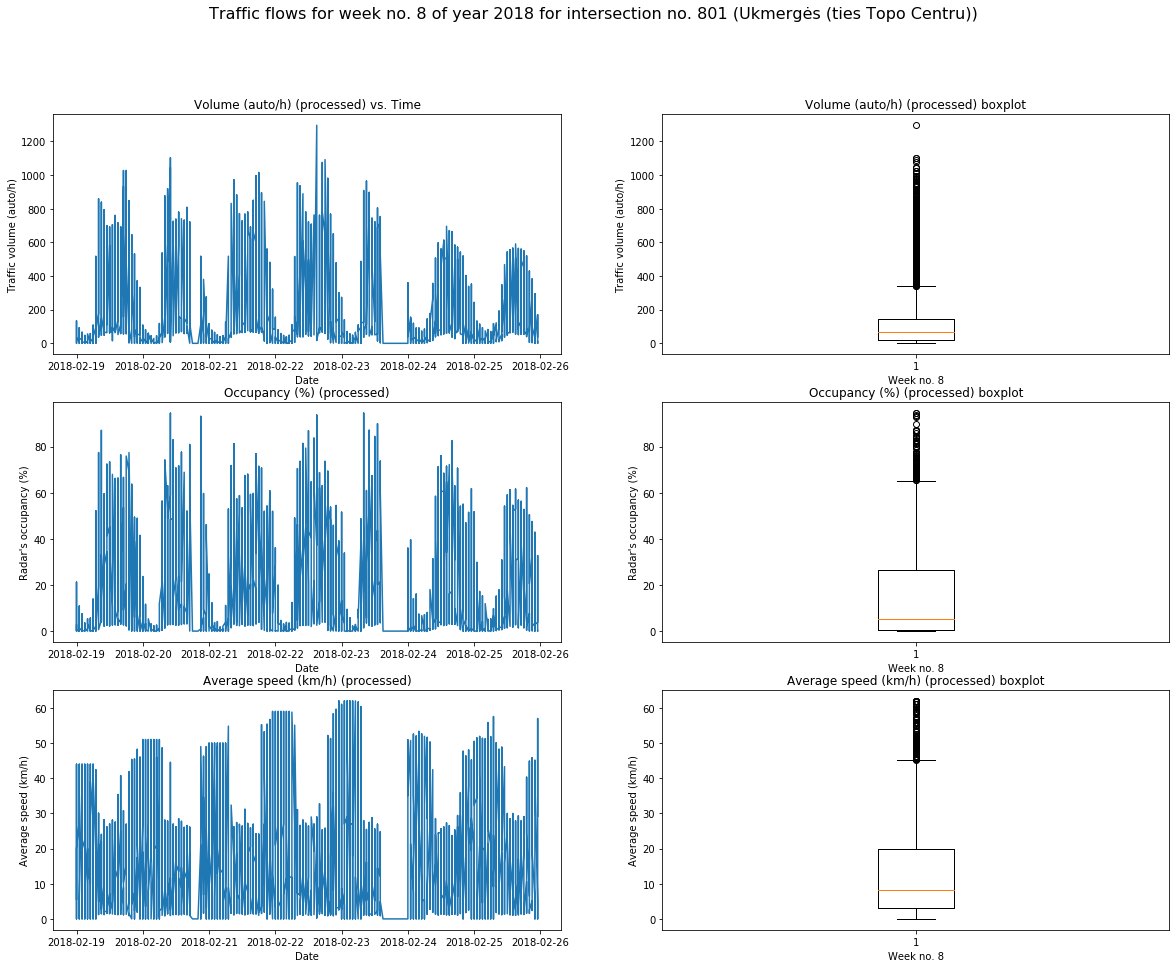

In [24]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

intersection_codes = list(set(traffic_flows_df["Code"].array))
random_week = random.randint(1, 52)
random_intersection = intersection_codes[random.randint(0, len(intersection_codes) - 1)]

sampled_data = traffic_flows_df[traffic_flows_df["Time"].dt.week == random_week]
intersection_i = traffic_intersection_mapping_df[traffic_intersection_mapping_df["Code"] == random_intersection]["Street"].iloc[0]

fig, axes = plt.subplots(nrows=3, 
                         ncols=2, 
                         sharex=False, 
                         sharey=False,
                         figsize=(20, 15))

fig.suptitle(f"Traffic flows for week no. {random_week} of year 2018 for intersection no. {random_intersection} ({intersection_i})",
             fontsize=16)

sampled_data_i = sampled_data[sampled_data["Code"] == random_intersection]
dates_i = sampled_data[sampled_data["Code"] == random_intersection]["Time"]

axes[0, 0].plot(dates_i,
                sampled_data_i["Volume (auto/h) (processed)"],
                label=random_intersection)

axes[0, 0].set_title("Volume (auto/h) (processed) vs. Time")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Traffic volume (auto/h)")

axes[0, 1].boxplot(sampled_data_i["Volume (auto/h) (processed)"])
axes[0, 1].set_title("Volume (auto/h) (processed) boxplot")
axes[0, 1].set_xlabel(f"Week no. {random_week}")
axes[0, 1].set_ylabel("Traffic volume (auto/h)")


axes[1, 0].plot(dates_i,
                sampled_data_i[["Occupancy (%) (processed)"]],
                label=random_intersection)

axes[1, 0].set_title("Occupancy (%) (processed)")
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Radar's occupancy (%)")

axes[1, 1].boxplot(sampled_data_i["Occupancy (%) (processed)"])
axes[1, 1].set_title("Occupancy (%) (processed) boxplot")
axes[1, 1].set_xlabel(f"Week no. {random_week}")
axes[1, 1].set_ylabel("Radar's occupancy (%)")

axes[2, 0].plot(dates_i,
                sampled_data_i[["Average speed (km/h) (processed)"]],
                label=random_intersection)

axes[2, 0].set_title("Average speed (km/h) (processed)")
axes[2, 0].set_xlabel("Date")
axes[2, 0].set_ylabel("Average speed (km/h)")

axes[2, 1].boxplot(sampled_data_i["Average speed (km/h) (processed)"])
axes[2, 1].set_title("Average speed (km/h) (processed) boxplot")
axes[2, 1].set_xlabel(f"Week no. {random_week}")
axes[2, 1].set_ylabel("Average speed (km/h)")    
    

Some insights for further chapters derived from initial exploration:
- Line plots are quite noisy, but it's visible that traffic volume and radar's occupancy spikes in the morning and in the evening;
- Some intersections appear to be not affected by the time of the day and plateu in a regular amount of occupancy and radar's volume;
- We previously observed the medium correlation between occupancy and volume, which is further confirmed by this plot.


*Feel free to rerun the block of code, it will give you another intersection and another week*

<br>

Save interim progress:

In [ ]:
traffic_flows_df.to_csv(BACKED_UP_TRAFFIC_FLOWS_PATH,
                        sep=";")

traffic_intersection_mapping_df.to_csv(BACKED_UP_INTERSECTION_MAPPING_PATH,
                                       sep=";")


<br>

## **2. Data representation and transformation** <a class="anchor" id="2"></a>

Purpose of this chapter is implement an appropriate transformation restructuring the originally given data into a new and more revealing form. Let's begin by loading in the interim data (if needed):

In [ ]:
if "traffic_flows_df" not in locals():
    try:
        traffic_flows_df = pd.read_csv(BACKED_UP_TRAFFIC_FLOWS_PATH,
                                       index_col=0,
                                       date_parser = pd.to_datetime,
                                       parse_dates = ["Time"],
                                       sep=",")
    except:
        raise Exception("(Flows) Backup doesn't exist, run parts 1.1. and 1.2. in order to proceed with analysis.")
    
if "traffic_intersection_mapping_df" not in locals():
    try:
        traffic_intersection_mapping_df = pd.read_csv(BACKED_UP_INTERSECTION_MAPPING_PATH,
                                                      index_col=0,
                                                      sep=';')
        
        traffic_intersection_mapping_df["Lattitude"] = traffic_intersection_mapping_df["Lattitude"].str.replace(",", ".").astype("float")
        traffic_intersection_mapping_df["Longitude"] = traffic_intersection_mapping_df["Longitude"].str.replace(",", ".").astype("float")
        
    except:
        raise Exception("(Mapping) Backup doesn't exist, run parts 1.1. and 1.2. in order to proceed with analysis.")
        

As mentioned before - I've decided to split this notebook to two distinct directions:
- One will be towards creating an interactive visualization of intersections of Vilnius;
- The other will be about the analysis of what could be causing the busy traffic.

Therefore there are two distict transformation chapters, one for each branch.

<br>

### **2.1. Transformations for further analysis** <a class="anchor" id="2.1"></a>

Given our insights from the last chapter, steps needed to be done for this part are the following:
 - Filter data to only the relevant days and times of the day, meaning that:
   - There should be no weekends or public holidays in the dataset;
   - Time frame for the analysis should be somewhere between 6 am. - 8 pm.
 - Discard intersections that are not valuable for analysis, meaning that:
   - We should filter out intersections which have a low variance (we'll set the threshold later in this chapter);

<br>

Let's start with filtering out weekends (traffic on weekends is almost always low and there's no school):

In [25]:
traffic_flows_df_analysis = traffic_flows_df[traffic_flows_df["Time"].dt.dayofweek < 5]

<br>

And continue to filtering out bank holidays (traffic on these days is also very low and there's no school thus they acts as an outlier):

In [26]:
bank_holidays = ["2018-01-01",  # January 1st (New Year)
                 "2018-02-16",  # February 16th (Independance day)
                 "2018-04-02",  # April 2nd (Easter)
                 "2018-05-01",  # May 1st (Labour day)
                 "2018-06-06",  # June 6h (Statehood day)
                 "2018-08-15",  # August 15th (Feast of assumption)
                 "2018-11-01",  # November 1st (All saints' day)
                 "2018-12-24",  # December 24th (Christmas eve)
                 "2018-12-25",  # December 25th (Christmas)
                 "2018-12-26"]  # December 26th (2nd day of christmas)

traffic_flows_df_analysis = traffic_flows_df_analysis[~traffic_flows_df_analysis["Time"].dt.date.astype(str).isin(bank_holidays)]


<br>

And finish off with filtering out the time (i've decided to eliminate nightime when there's barely any traffic).

In [27]:
traffic_flows_df_analysis = traffic_flows_df_analysis.set_index("Time").between_time("05:00", "20:00")
traffic_flows_df_analysis.reset_index(inplace=True, drop=False)

<br>

Let's inspect:

In [28]:
traffic_flows_df_analysis.shape

(9612048, 5)

In [29]:
traffic_flows_df_analysis.describe()

,Volume (auto/h) (processed),Occupancy (%) (processed),Average speed (km/h) (processed)
count,"9,612,048.00","9,612,048.00","9,612,048.00"
mean,209.45,10.85,21.27
std,198.12,14.19,14.69
min,-1.00,0.00,-1.00
25%,48.75,1.60,8.71
50%,154.06,5.95,20.59
75%,321.04,13.90,31.25
max,"2,482.00",100.00,161.96


###### <br>

Next step is to sort intersections by their variance and the decide where the decision boundary shal be, let's start with calculating variance for each feature of each intersection and plotting the result as bar plots:

In [30]:
traffic_flows_df_analysis_grouped = traffic_flows_df_analysis.groupby(by="Code").var()

traffic_flows_df_analysis_grouped_vol = traffic_flows_df_analysis_grouped[["Volume (auto/h) (processed)"]].sort_values(by="Volume (auto/h) (processed)", ascending=False).reset_index(drop=False)
traffic_flows_df_analysis_grouped_occ = traffic_flows_df_analysis_grouped[["Occupancy (%) (processed)"]].sort_values(by="Occupancy (%) (processed)", ascending=False).reset_index(drop=False)
traffic_flows_df_analysis_grouped_spd = traffic_flows_df_analysis_grouped[["Average speed (km/h) (processed)"]].sort_values(by="Average speed (km/h) (processed)", ascending=False).reset_index(drop=False)

traffic_flows_df_analysis_grouped.reset_index(drop=False, inplace=True)


*I've chosen variance because it's a good metric to visualize the volatility of the traffic. If it's low, then there's little point in inferring any insights from that intersection, it might even be misleading in some cases.*

Text(0.5, 0, 'No. of observation')

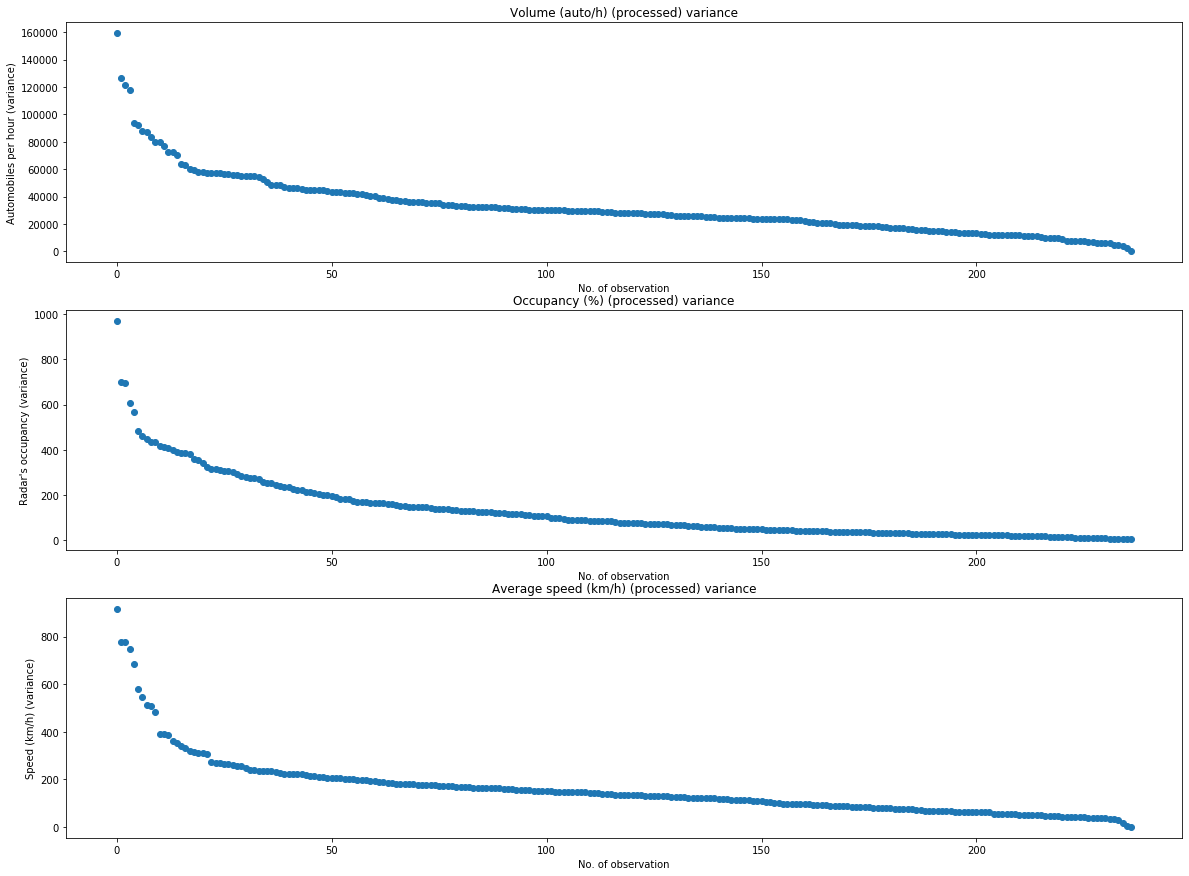

In [31]:
fig, axes = plt.subplots(nrows=3, 
                         ncols=1, 
                         sharex=False, 
                         sharey=False,
                         figsize=(20, 15))

axes[0].scatter(np.arange(0, traffic_flows_df_analysis_grouped_vol.shape[0], 1),
             traffic_flows_df_analysis_grouped_vol["Volume (auto/h) (processed)"])

axes[1].scatter(np.arange(0, traffic_flows_df_analysis_grouped_occ.shape[0], 1),
               traffic_flows_df_analysis_grouped_occ["Occupancy (%) (processed)"])

axes[2].scatter(np.arange(0, traffic_flows_df_analysis_grouped_spd.shape[0], 1),
               traffic_flows_df_analysis_grouped_spd["Average speed (km/h) (processed)"])

axes[0].set_title("Volume (auto/h) (processed) variance")
axes[1].set_title("Occupancy (%) (processed) variance")
axes[2].set_title("Average speed (km/h) (processed) variance")

axes[0].set_ylabel("Automobiles per hour (variance)")
axes[1].set_ylabel("Radar's occupancy (variance)")
axes[2].set_ylabel("Speed (km/h) (variance)")

axes[0].set_xlabel("No. of observation")
axes[1].set_xlabel("No. of observation")
axes[2].set_xlabel("No. of observation")


Although every intersection has a decent amount of variance, only the top 25 seem to be significant (there are no tests for variance significance from 0, so we have to trust our intuition here).

In [32]:
top_25_intersections = traffic_flows_df_analysis_grouped.sort_values(by=["Volume (auto/h) (processed)"], ascending=False).iloc[:25]["Code"].to_list()
traffic_flows_df_analysis_top25 = traffic_flows_df_analysis[traffic_flows_df_analysis["Code"].isin(top_25_intersections)]
traffic_flows_df_analysis_top25 = traffic_flows_df_analysis_top25.groupby(by="Time").mean()

traffic_flows_df_analysis_top25.shape


(4016, 3)

We're left with ~4000 rows.

<br>

### **2.2. Transformations for a dashboard** <a class="anchor" id="2.2"></a>

Our goal here is for every intersection to plot a marker indicating the business of that intersection. For this we will need to do some grouping first:

In [33]:
traffic_flows_df_dashboard = traffic_flows_df_analysis.set_index("Time").between_time("07:00", "09:00").reset_index(drop=False)
traffic_flows_df_dashboard = traffic_flows_df_dashboard.groupby(by=["Code"]).mean()

We're narrowed the time window even more (to 7 am. - 9 am.) to have the best possible picture of the traffic on any particular day.

<br>

Then, we should join the coordinates to our traffic data frame and inspect:

In [34]:
traffic_flows_df_coord_dashboard = pd.concat([traffic_flows_df_dashboard, traffic_intersection_mapping_df.set_index('Code')],
                                             axis=1,
                                             sort=False).dropna()

traffic_flows_df_coord_dashboard.head()

,Volume (auto/h) (processed),Occupancy (%) (processed),Average speed (km/h) (processed),Longitude,Lattitude,Street
1001,387.06,9.65,28.47,"25,286866","54,698668",Rinktinės-Kazliškių
1002,361.37,10.02,26.71,"25,300914","54,697964",Žirmūnų pėsc. ties IKI
1003,198.10,12.41,14.69,"25,308601","54,685154",Olandų - Filaretų
1004,207.93,4.55,34.60,"25,301221","54,677212",Subačiaus g.(pesčiųjų perėja)
1005,337.92,14.61,23.90,"25,311172","54,678638",Zarasų - Paplaujos


<br>

## **3. Causation analysis** <a class="anchor" id="3"></a>

### **3.1. School holidays** <a class="anchor" id="3.1"></a>

In this section we'll try to evaluate the impact that school's holidays have on traffic.

Schoold holidays on 2018 were on the following periods:
- Early spring break from February 18th till 22nd;
- Easter break from April 2nd till 6th;
- Autumn break from October 29th till November 2nd;

Let's filter out data accordingly:

In [35]:
school_holidays = ["2018-02-18",
                   "2018-02-19",
                   "2018-02-20",
                   "2018-02-21",
                   "2018-02-22",
                   "2018-04-02",
                   "2018-04-03",
                   "2018-04-04",
                   "2018-04-05",
                   "2018-04-06",
                   "2018-10-29",
                   "2018-10-30",
                   "2018-10-31",
                   "2018-11-01",
                   "2018-11-02"]

traffic_flows_df_analysis_school = traffic_flows_df_analysis_top25.reset_index(drop=False)

traffic_flows_df_analysis_school_non_holidays = traffic_flows_df_analysis_school[~traffic_flows_df_analysis_school['Time'].dt.date.astype(str).isin(school_holidays)]
traffic_flows_df_analysis_school_non_holidays['Hour'] = traffic_flows_df_analysis_school_non_holidays['Time'].dt.hour
traffic_flows_df_analysis_school_non_holidays = traffic_flows_df_analysis_school_non_holidays.groupby(by='Hour').mean()

traffic_flows_df_analysis_school_holidays = traffic_flows_df_analysis_school[traffic_flows_df_analysis_school['Time'].dt.date.astype(str).isin(school_holidays)]
traffic_flows_df_analysis_school_holidays['Hour'] = traffic_flows_df_analysis_school_holidays['Time'].dt.hour
traffic_flows_df_analysis_school_holidays = traffic_flows_df_analysis_school_holidays.groupby(by='Hour').mean()


We've split our dataset into two groups: when there were school holidays; and when there weren't.

<br>

It would be also a good idea to check a p-value of whether averages of these two subsets differ significantly:

In [36]:
t_test_volume = stats.ttest_ind(traffic_flows_df_analysis_school_non_holidays['Volume (auto/h) (processed)'],
                                traffic_flows_df_analysis_school_holidays['Volume (auto/h) (processed)'])

t_test_occup = stats.ttest_ind(traffic_flows_df_analysis_school_non_holidays['Occupancy (%) (processed)'],
                               traffic_flows_df_analysis_school_holidays['Occupancy (%) (processed)'])

t_test_speed = stats.ttest_ind(traffic_flows_df_analysis_school_non_holidays['Average speed (km/h) (processed)'],
                               traffic_flows_df_analysis_school_holidays['Average speed (km/h) (processed)'])


print(f'''Results for the p-values of the t-tests are the following:

- Volume (auto/h) (processed) - {t_test_volume[1]};
- Occupancy (%) (processed) - {t_test_occup[1]};
- Average speed (km/h) (processed) - {t_test_speed[1]}.
''')


Results for the p-values of the t-tests are the following:

- Volume (auto/h) (processed) - 0.7404856982391909;
- Occupancy (%) (processed) - 0.68098113747564;
- Average speed (km/h) (processed) - 0.8780976811609902.



Our p-value is high which would suggest that a null hipothesis must be accepted and that there is in fact no difference between two subsets of data.

<br>

For our last attempt, let's try to plot these two subsets and observe them visually:

<IPython.core.display.Javascript object>


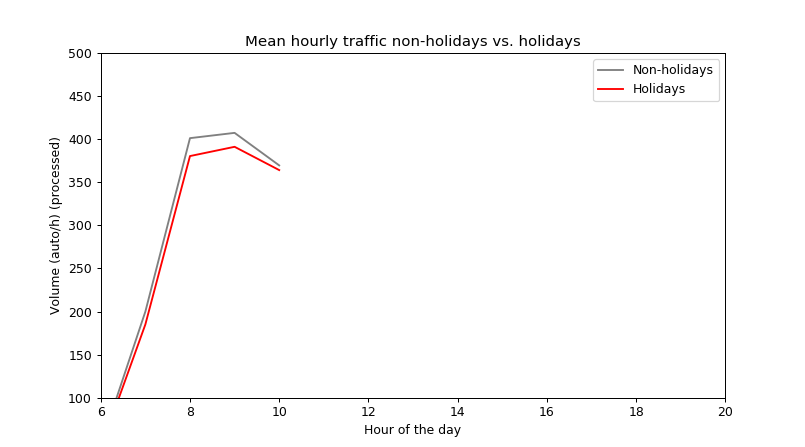

In [44]:
%matplotlib notebook

import matplotlib.animation as animation

traffic_flows_df_analysis_school_non_holidays_anim = traffic_flows_df_analysis_school_non_holidays.reset_index(drop=False)
traffic_flows_df_analysis_school_holidays_anim = traffic_flows_df_analysis_school_holidays.reset_index(drop=False)

def update(curr):
    if curr == 200:
        a.event_source.stop()
        
    plt.cla()
    
    plt.plot(traffic_flows_df_analysis_school_non_holidays_anim['Hour'].iloc[:curr//10],
             traffic_flows_df_analysis_school_non_holidays_anim['Volume (auto/h) (processed)'].iloc[:curr//10],
             c='grey',
             label='Non-holidays')
    
    plt.plot(traffic_flows_df_analysis_school_holidays_anim['Hour'].iloc[:curr//10],
             traffic_flows_df_analysis_school_holidays_anim['Volume (auto/h) (processed)'].iloc[:curr//10],
             c='red',
             label='Holidays')
    
    plt.gca().set_ylabel('Volume (auto/h) (processed)')
    plt.gca().set_xlabel('Hour of the day')
    plt.gca().set_title('Mean hourly traffic non-holidays vs. holidays')
    plt.gca().set_xbound(6, 20)
    plt.gca().set_ybound(100, 500)
    
    plt.legend()
    
fig = plt.figure(figsize=(9, 5))

a = animation.FuncAnimation(fig,
                            update,
                            interval=1,
                            repeat=True,
                            frames=200)


**This is an animated graph, but for it to work - cell has to be rerun.

<br>

## **4. Data visualization and presentation** <a class="anchor" id="4"></a>

In this section we'll plot the mean (yearly) traffic conditions during peak hours on a folium map:

In [45]:
import folium

map_of_vilnius = folium.Map(location=[54.6991274, 25.271893],
                            zoom_start=14.25)
 
labels = ('Intersection \"'
          + traffic_flows_df_coord_dashboard['Street'] 
          + '\", during peak time (7-9 am.), on average, gets passed by '
          + traffic_flows_df_coord_dashboard['Volume (auto/h) (processed)'].astype(int).astype(str)
          + ' cars per hour at '
          + traffic_flows_df_coord_dashboard['Average speed (km/h) (processed)'].astype(int).astype(str)
          + ' km//h.'
          + ' Where radar occupancy is at: '
          + traffic_flows_df_coord_dashboard['Occupancy (%) (processed)'].astype(int).astype(str)
          + '%.' )
    
for vol, lat, lng, label in zip(traffic_flows_df_coord_dashboard['Volume (auto/h) (processed)'],
                                traffic_flows_df_coord_dashboard['Lattitude'].str.replace(',', '.').astype(float),
                                traffic_flows_df_coord_dashboard['Longitude'].str.replace(',', '.').astype(float),
                                labels):
    
    if vol < 200:
        color = 'green'
    elif 200 < vol < 300:
        color = 'yellow'
    else:
        color = 'red'
    
    folium.CircleMarker([lat, lng],
                        radius=5, 
                        color=color,
                        fill=True,
                        popup=label,
                        fill_color='white',
                        fill_opacity=0.6).add_to(map_of_vilnius)

map_of_vilnius

**Click on every intersection for more info!**